In [1]:
## import time
import sys
print(sys.path)

sys.path.insert(0,'/home/kaechben/JetNet_NF/LitJetNet/LitNF')
sys.path.insert(0, "/home/kaechben/JetNet_NF/LitJetNet/normalizing_flows_pytorch")
# from flows2 import Ffjord
# from flows2.main import Model
import json
import traceback
import copy
from scipy import interpolate
from scipy.stats import norm
from nflows.flows.base import Flow
from nflows.utils.torchutils import create_random_binary_mask
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import *
from nflows.transforms import *
from nflows.nn import nets
from nflows.transforms.coupling import *
from nflows.transforms.autoregressive import *
from nflows.transforms.permutations import ReversePermutation
import traceback
from neural_spline_flows.nde.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from neural_spline_flows.nde.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from neural_spline_flows.nn import ResidualNet
from neural_spline_flows.utils import create_alternating_binary_mask
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torch import autograd
from torch.autograd import grad
from torch.nn import functional as FF
import numpy as np
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import *
import pandas as pd
import matplotlib.pyplot as plt
import os
import jetnet 
from jetnet.evaluation import w1p,w1efp,w1m,cov_mmd,fpnd

import nflows as nf
import matplotlib.pyplot as plt
import mplhep as hep
import hist
from hist import Hist
# import ctypes
from markdown import markdown
#import inspect
from pytorch_lightning.loggers import TensorBoardLogger
from collections import OrderedDict
print("imports ok")
print(torch.cuda.is_available())
from torch.optim.lr_scheduler import CyclicLR,OneCycleLR
from torch import optim

from nflows import flows
from nflows.flows import base
from plotting import plotting
from helpers import *
from jetnet_dataloader import JetNetDataloader
from particle_net import ParticleNet
from torch_geometric.data import Batch,Data
import torch_geometric.transforms as T


['/home/kaechben/JetNet_NF/LitJetNet/LitNF', '/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python38.zip', '/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8', '/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/lib-dynload', '', '/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages']
imports ok
True


In [2]:
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl   
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from helpers import *
from nflows.distributions.base import Distribution
import matplotlib.pyplot as plt

class StandardScaler:

    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)
    def inverse_transform(self,values):
        return (values *self.std)+self.mean
    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)
    def to(self,dev):
        self.std=self.std.to(dev)
        self.mean=self.mean.to(dev)
        return self
  

class JetNetDataloader(pl.LightningDataModule):
    '''This is more or less standard boilerplate coded that builds the data loader of the training
       one thing to note is the custom standard scaler that works on tensors
       Currently only jets with 30 particles are used but this maybe changes soon'''
    def __init__(self,config): 
        super().__init__()
        self.config=config
        self.n_dim=config["n_dim"]
        self.batch_size=config["batch_size"]
    def setup(self,stage):
    # This just sets up the dataloader, nothing particularly important. it reads in a csv, calculates mass and reads out the number particles per jet
    # And adds it to the dataset as variable. The only important thing is that we add noise to zero padded ets
        data_dir=os.environ["HOME"]+"/JetNet_NF/train_{}_jets.csv".format(self.config["parton"])
        data=pd.read_csv(data_dir,sep=" ",header=None)
        jets=[]
        limit=int(self.config["limit"]*1.1)
        for njets in range(1,31):
            masks=np.sum(data.values[:,np.arange(3,120,4)],axis=1)
            df=data.loc[masks==njets,:]
            df=df.drop(np.arange(3,120,4),axis=1)
            df["n"]=njets
            if len(df)>100:
                jets.append(df[:self.config["limit"]])
        self.n=torch.empty((0,1))
        self.data=torch.empty((0,90))
        for i in range(len(jets)):
            x=torch.tensor(jets[i].values[:,:self.n_dim]).float()
            n=torch.tensor(jets[i]["n"].values).float()
            self.data=torch.vstack((self.data,x))
            self.n=torch.vstack((self.n.reshape(-1,1),n.reshape(-1,1)))        
        self.scaler=StandardScaler()
        if self.config["canonical"]:
            self.data=preprocess(self.data)        
        self.m=mass(self.data[:,:self.n_dim],self.config["canonical"]).reshape(-1,1)  
      # Adding noise to the mass of the jets.
        for i in torch.unique(self.n):
            i=int(i)
            self.data[self.data[:,-1]==i,3*i:90]=torch.normal(mean=torch.zeros_like(self.data[self.data[:,-1]==i,3*i:90]),std=1).abs()*1e-7
        if self.config["context_features"]:
            self.data=torch.hstack((self.data,self.m))        
        self.scaler.fit(self.data)
        self.data=self.scaler.transform(self.data)
        if self.config["context_features"]>1:
            self.data=torch.hstack((self.data,self.n))
        
        #calculating mass dist in different bins, this is needed for the testcase where we need to generate the conditoon
        if self.config["variable"]:
            self.mdists={}
            for i in torch.unique(self.n):
                self.mdists[int(i)]=F(self.data[self.data[:,-1]==i,-2])    
        self.data,self.test_set=train_test_split(self.data.cpu().numpy(),test_size=0.1)
        self.test_set=torch.tensor(self.test_set).float()
        self.data=torch.tensor(self.data).float()
        assert (torch.isnan(self.data)).sum()==0
        assert self.data.shape[1]==self.n_dim+self.config["context_features"]

    def train_dataloader(self):
        return DataLoader(self.data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.test_set, batch_size=len(self.test_set))


In [3]:

class LitNF(pl.LightningModule):
    
   
    def create_resnet(self,in_features, out_features):
        '''This is the network that outputs the parameters of the invertible transformation
        The only arguments can be the in dimension and the out dimenson, the structure
        of the network is defined over the config which is a class attribute
        Context Features: Amount of features used to condition the flow - in our case 
        this is usually the mass
        num_blocks: How many Resnet blocks should be used, one res net block is are 1 input+ 2 layers
        and an additive skip connection from the first to the third'''
        c=self.config["context_features"]
        return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=self.config["network_nodes"],
                context_features=c,
                num_blocks=self.config["network_layers"],
                activation=self.config["activation"]  if "activation" in self.config.keys() else FF.relu,
                dropout_probability=self.config["dropout"] if "dropout" in self.config.keys() else 0,
                use_batch_norm=self.config["batchnorm"] if "batchnorm" in self.config.keys() else 0,

                    )
    def __init__(self,config):
        
        '''This initializes the model and its hyperparameters'''
        super().__init__()
        self.config=config
        
        #Metrics to track during the training
        self.metrics={"w1p":[],"w1m":[],"w1efp":[],"cov":[],"mmd":[],"fpnd":[]}
        #Loss function of the Normalizing flows
        self.logprobs=[]

        self.hparams.update(config)
        self.save_hyperparameters()
        #This is the Normalizing flow model to be used later, it uses as many
        #coupling_layers as given in the config 
        self.flows = []
        self.n_dim=self.config["n_dim"]
        K=self.config["coupling_layers"]
        for i in range(K):
            '''This creates the masks for the coupling layers, particle masks are masks
            created such that each feature particle (eta,phi,pt) is masked together or not'''
            mask=create_random_binary_mask(self.n_dim)  
            if "particle_masks" in self.config.keys() and self.config["particle_masks"] :
                mask=create_random_binary_mask(self.n_dim//3)            
                mask=mask.repeat_interleave(3)
            #Here are the coupling layers of the flow. There seem to be 3 choices but actually its more or less only 2
            #The autoregressive one is incredibly slow while sampling which does not work together with the constraint
            if self.config["spline"]:
                self.flows += [PiecewiseRationalQuadraticCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=self.create_resnet, 
                    tails='linear',
                    tail_bound=self.config["tail_bound"],
                    num_bins=self.config["bins"] )]
            elif self.config["autoreg"]:
                self.flows += [MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                    features=self.n_dim,
                    num_blocks=self.config["network_layers"], 
                    hidden_features=self.config["network_nodes"],
                    context_features=self.config["context_features"] ,
                    tails='linear',
                    tail_bound=self.config["tail_bound"],
                    num_bins=self.config["bins"],
                    use_residual_blocks=True,
                    use_batch_norm=self.config["batchnorm"],
                    activation=self.config["activation"])]
            else:
                self.flows+=[ AffineCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=self.create_resnet)]
        #This sets the distribution in the latent space on which we want to morph onto        
        self.q0 = nf.distributions.normal.StandardNormal([self.n_dim])
        self.q_test =nf.distributions.normal.StandardNormal([self.n_dim])
        #Creates working flow model from the list of layer modules
        self.flows=CompositeTransform(self.flows)
        # Construct flow model
        self.flow_test= base.Flow(distribution=self.q_test, transform=self.flows)
        self.flow = base.Flow(distribution=self.q0, transform=self.flows)
        
    def build_disc(self,config=None):
        '''this builds a discriminator that can be used to distinguish generated from real
        data, optimally we would want it to have a 50% accuracy, meaning it can distinguish
        This is just a Feed Forward Neural Network
        The wgan keyword makes it a Wasserstein type of discriminator/critic
        I played around with this but it did not work particularly well'''
        if config:
                settings = {
                "conv_params": [
                    (8, (64, 64, 64)),
                    (8, (128, 128, 128)),
                    (8, (128, 128, 128)),
                ],
                "fc_params": [
                    (0.0, 128)
                ],
                "input_features": 3,
                "output_classes": self.config["context_features"]}
                self.particle_net=ParticleNet(settings)
                
                return 0


    def load_datamodule(self,data_module):
        '''needed for lightning training to work, it just sets the dataloader for training and validation'''
        self.data_module=data_module
        
    def on_after_backward(self) -> None:
        '''This is a genious little hook, sometimes my model dies, i have no clue why. This saves the training from crashing and continues'''
        valid_gradients = True
        for name, param in self.named_parameters():
            if param.grad is not None:
                valid_gradients = not (torch.isnan(param.grad).any() or torch.isinf(param.grad).any())
                if not valid_gradients:
                    break
        if not valid_gradients:
            self.zero_grad()
    def sampleandscale(self,batch,c=None,n=None):
        '''This is a helper function that samples from the flow (i.e. generates a new sample) 
            and reverses the standard scaling that is done in the preprocessing. This allows to calculate the mass
            on the generative sample and to compare to the simulated one, we need to inverse the scaling before calculating the mass
            because calculating the mass is a non linear transformation and does not commute with the mass calculation''' 
        x= batch[:,:self.n_dim].to(self.device),
        n_c=self.config["context_features"]
        if n_c>0:            
            c= batch[:,self.n_dim:].reshape(-1,n_c).to(self.device) if c==None else c
            gen=self.flow.sample(1,c.reshape(-1,n_c)).reshape(-1,self.n_dim).to(self.device)
        else:
            gen=self.flow.sample(len(batch)).reshape(-1,self.n_dim).to(self.device)
        #This make sure that everything is on the right device
        self.data_module.scaler.to(self.device)
        self.flow.to(self.device)
        #Not here that this sample is conditioned on the mass of the current batch allowing the MSE 
        #to be calculated later on
        gen=self.data_module.scaler.inverse_transform(torch.hstack((gen[:,:self.n_dim]
            .reshape(-1,self.n_dim),torch.ones(len(gen)).to(self.device).unsqueeze(1))))
        true=self.data_module.scaler.inverse_transform(batch[:,:self.n_dim+1].to(self.device)).to(self.device)
        m=true[:,self.n_dim]
        m_g=mass(gen[:,:self.n_dim].to(self.device) ,
                 self.config["canonical"]).to(self.device)
        gen=torch.column_stack((gen,m_g))
        return gen,true,m,m_g
        
    def configure_optimizers(self):
        self.batch_size=self.config["batch_size"]
        #learning rate
        self.lr=self.config["lr"]
        #Total Loss (can be a sum of multiple terms)
        self.losses=[]
        #mlosses are initialized with None during the time it is not turned on, makes it easier to plot
        self.mlosses=[None for i in range(min(self.config["n_mse_delay"],self.config["max_steps"]))]
        self.n_dim=self.config["n_dim"]  
        opt_g = torch.optim.AdamW(self.flow.parameters(), lr=self.lr)
        self.opt_g=opt_g
        if self.config["lr_schedule"]:
            scheduler = OneCycleLR(self.opt_g,max_lr=0.01,self.config["max_steps"])
        return ({'optimizer': opt_g, 'frequency': 1, 'scheduler':scheduler if self.config["lr_schedule"] else None})
    def test_cond(self,num):
        """this sampels mass and number particle conditions in an autoregressive manner needed for data generation, 
            First the number particles are sampeled randomly from the pmf, and then the mass distribution for every case with 
            n particles is calculated - this distribution is then interpolated and a 1d flows is constructed """
        ns=self.data_module.n[torch.randint(low=0,high=len(self.data_module.n),size=(num,))]
        c=torch.empty((0,2))
        counts=torch.unique(ns,return_counts=True)
        for n,count in zip(counts[0],counts[1]):
            m_temp=torch.tensor(self.data_module.mdists[int(n)][1](torch.rand(size=(count,)).numpy())).reshape(-1,1).float()
            n_temp=torch.tensor(int(n)).repeat(count).reshape(-1,1)
            c_temp=torch.hstack((m_temp,n_temp))
            c=torch.vstack((c,c_temp))
        return c
    def training_step(self, batch, batch_idx,optimizer_idx=0,wgan=False):
        """training loop of the model, here all the data is passed forward to a gaussian
            This is the important part what is happening here. This is all the training we do """
        x,c= batch[:,:self.n_dim],batch[:,self.n_dim:]
        self.opt_g.zero_grad()
        
        # This is the mass constraint, which constrains the flow to generate events with a mass which is the same as the mass it has been conditioned on, we can choose to not calculate this when we work without mass constraint to make training faster
        if self.config["calc_massloss"]  :
                self.gen,self.true,self.m,self.m_g=self.sampleandscale(batch,c=c)

                mloss=FF.mse_loss(self.m_g.to(self.device).reshape(-1),self.m.to(self.device).reshape(-1))
                assert not torch.any(self.m_g.isnan()) or not torch.any(self.m.isnan())
                self.mlosses.append(mloss.detach().cpu().numpy())
                self.log("mass_loss", mloss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        ##Normalizing Flow loss Normalizing Flow loss
        g_loss = -self.flow.to(self.device).log_prob(x,c if self.config["context_features"] else None).mean()/self.n_dim
        self.log("logprob", g_loss, on_step=True, on_epoch=False, prog_bar=True, logger=True) 
        self.logprobs.append(g_loss.detach().cpu().numpy())
        #some conditions on when we want to actually add the mass loss to our training loss, if we dont add it, it is as it wouldnt exist
        if self.global_step>self.config["n_mse_delay"] and self.config["context_features"]>0 and self.config["calc_massloss"] and self.global_step<self.config["n_mse_turnoff"]:
            g_loss+=self.config["lambda"]*mloss
            self.log("combined_loss", g_loss, on_epoch=True, prog_bar=True, logger=True)
        self.losses.append(g_loss.detach().cpu().numpy())
        return OrderedDict({"loss":g_loss})
        
    def validation_step(self, batch, batch_idx):
        '''This calculates some important metrics on the hold out set (checking for overtraining)'''
        self.data_module.scaler.to("cpu")  
        batch=batch.to("cpu")
        c=batch[:,-self.config["context_features"]:] #this is the condition
        c_test=self.test_cond(len(batch))#this is the condition in the case of testing
        with torch.no_grad():
            if self.config["context_features"]:
                gen=self.flow_test.to("cpu").sample(1,c).to("cpu")
                test=self.flow_test.to("cpu").sample(1,c_test.float()).to("cpu")
                gen=torch.hstack((gen[:,:self.n_dim].cpu().detach().reshape(-1,self.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
                test=torch.hstack((test[:,:self.n_dim].cpu().detach().reshape(-1,self.n_dim),torch.ones(len(test)).unsqueeze(1)))
            else:
                gen=self.flow.to("cpu").sample(len(batch)).to("cpu")
                test=self.flow.to("cpu").sample(len(batch)).to("cpu")
        # Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
        test=self.data_module.scaler.inverse_transform(test)
        gen=self.data_module.scaler.inverse_transform(gen)
        true=self.data_module.scaler.inverse_transform(batch[:,:self.n_dim+1])
        # We overwrite in cases where n is smaller 30 the particles after n with 0
        if self.config["context_features"]>1:
            for i in torch.unique(batch[:,-1]):
                i=int(i)
                gen[c[:,-1]==i,3*i:]=0
                test[c_test[:,-1]==i,3*i:-1]=0
        true=true[:,:self.n_dim]
        #This is just a nice check to see whether we overtrain 
        logprob = -self.flow.to("cpu").log_prob(batch[:,:self.n_dim],batch[:,self.n_dim:]).detach().mean().numpy()/self.n_dim
        
        #calculate mass distrbutions & concat them to training sample
        m_t=mass(true[:,:self.n_dim].to(self.device),self.config["canonical"]).cpu()
        m_gen=mass(gen[:,:self.n_dim],self.config["canonical"]).cpu()
        m_test=mass(test[:,:self.n_dim],self.config["canonical"]).cpu()
        gen=torch.column_stack((gen[:,:90],m_gen))
        test=torch.column_stack((test[:,:90],m_test))       
        # Again checking for overtraining
        mse=FF.mse_loss(m_t,m_test).detach()

        if self.config["canonical"]:
            gen[:,:90]=preprocess(gen[:,:90],rev=True)
            test[:,:90]=preprocess(test[:,:90],rev=True)
        # For one metric the pt needs to always be bigger or equal 0, so we overwrite the cases where it isnt (its not physical possible to ahve pt smaller 0)
        for i in range(30):
            i=2+3*i
            gen[gen[:,i]<0,i]=0
            test[test[:,i]<0,i]=0
            true[true[:,i]<0,i]=0
        #Some metrics we track
        cov,mmd=cov_mmd(gen[:,:self.n_dim].reshape(-1,self.n_dim//3,3),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3),use_tqdm=False)
        fpndv=fpnd(gen[:,:self.n_dim].reshape(-1,self.n_dim//3,3).numpy(),use_tqdm=False,jet_type=self.config["parton"])

        self.metrics["fpnd"].append(fpndv)
        self.metrics["mmd"].append(mmd)
        self.metrics["cov"].append(cov)
        self.metrics["w1p"].append(w1p(gen[:,:self.n_dim].reshape(-1,self.n_dim//3,3).numpy(),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        self.metrics["w1m"].append(w1m(gen[:,:self.n_dim].reshape(-1,self.n_dim//3,3).numpy(),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        self.metrics["w1efp"].append(w1efp(gen[:,:self.n_dim].reshape(-1,self.n_dim//3,3).numpy(),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        
        self.log("val_w1m",self.metrics["w1m"][-1][0],on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_w1p",self.metrics["w1p"][-1][0],on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_w1efp",self.metrics["w1efp"][-1][0],on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_logprob",logprob,prog_bar=True,logger=True)
        self.log("val_cov",cov,prog_bar=True,logger=True,on_step=False, on_epoch=True)
        self.log("val_fpnd",fpndv,prog_bar=True,logger=True,on_step=False, on_epoch=True)
        self.log("val_mmd",mmd,prog_bar=True,logger=True,on_step=False, on_epoch=True)
        self.log("val_mse",mse,prog_bar=True,logger=True,on_step=False, on_epoch=True)
        # This part here adds the plots to tensorboard
        self.plot=plotting(model=self,gen=test[:,:self.n_dim],true=true[:,:self.n_dim],config=self.config,step=self.global_step,logger=self.logger.experiment)
        self.flow=self.flow.to(self.device)
        try:
            self.plot.plot_mass(m_test.cpu().numpy(),m_t.cpu().numpy(),save=True,bins=30,quantile=True,plot_vline=False)
#             self.plot.plot_marginals(save=True)
            self.plot.plot_2d(save=True)
            self.plot.losses(save=True)
        
        except Exception as e:
            traceback.print_exc()
            
# #         self.flow.to("cuda")
        self.plot.plot_correlations()



SyntaxError: positional argument follows keyword argument (2744079895.py, line 158)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.datasets import make_moons
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
# from flows2 import Ffjord
# from flows2.main import Model
config = {
            "network_layers": 2,  # sets amount hidden layers in transformation networks
            "network_nodes": 256,  # amount nodes in hidden layers in transformation networks
            "batch_size": 7500,  # sets batch size
            "coupling_layers": 15,  # amount of invertible transformations to use
            "lr": 0.001,  # sets learning rate
            "batchnorm": False,  # use batchnorm or not
            "autoreg": False,  # whether to use autoregressive transform, alot slower together with calc_massloss or massloss
            "bins": 8,  # amount of bins to use in rational quadratic splines
            "UMNN": False,  # whether to use monotonic network instead of splines in trafo
            "tail_bound": 6,  # splines:max value that is transformed, over this value theree is id
            "limit": 100000,  # how many data points to use, test_set is 10% of this
            "n_dim": 90,  # how many dimensions to use or equivalently /3 gives the amount of particles to use
            "dropout": 0.4,  # use droput proportion, for 0 there is no dropout
            "lr_schedule": False,  # whether tos chedule the learning rate
            "gamma": 0.75,  # gamma that is annealing the learning rate
            "canonical": False,  # transform data coordinates to px,py,pz
            "max_steps": 5000,  # how many steps to use at max
            "lambda": 1,  # balance between massloss and nll
            "n_mse_turnoff": 1000,  # when to turn off mass loss
            "n_mse_delay": 5,  # when to turn on mass loss
            "name": "pointflow",  # name for logging folder
            "disc": False,  # whether to train gan style discriminator that decides whether point is simulated or generated
            "calc_massloss": True, # whether to calculate mass loss, makes training slower, do not use with autoregressive!
            "context_features":2, #amount of variables used for conditioning, for 0 no conditioning is used, for 1 only the mass is used, for 2 also the number part is used
            "variable":1, #use variable amount of particles otherwise only use 30, options are true or false 
            "spline":True,#whether to use splines or not.
            "parton":"q" #choose the dataset you want to train options: t for top,q for quark,g for gluon
        }
from pytorch_lightning.callbacks import DeviceStatsMonitor

data_module = JetNetDataloader(config)
model=LitNF(config=config)
checkpoint_callbacks = [
                        ModelCheckpoint(monitor="val_w1m",dirpath=",/",filename="best_mass-{}".format(config["n_dim"])),
                         ModelCheckpoint(monitor="val_w1p",filename="best_logprob-{}".format(config["n_dim"])),
DeviceStatsMonitor()]
path="lightning_logs/pointflow/version_0/checkpoints/"
ckpt=os.listdir(path)[0]
model=LitNF.load_from_checkpoint(path+ckpt)

model.load_datamodule(data_module)
model.config=config

logger= TensorBoardLogger("lightning_logs", name=config["name"],log_graph=False)

trainer = pl.Trainer(gpus=1,log_every_n_steps=1,#auto_scale_batch_size="binsearch",
                     auto_lr_find=False,max_epochs=-1,callbacks=checkpoint_callbacks,
                     gradient_clip_val=50, gradient_clip_algorithm="value",check_val_every_n_epoch=1  
                    ,fast_dev_run=0,logger=logger,stochastic_weight_avg=False,num_sanity_val_steps=1)#,track_grad_norm=2,detect_anomaly=True
# # # trainer.tune(model,data_module)
# # # # lr_finder = trainer.tuner.lr_find(model,data_module, early_stop_threshold=100, min_lr=1e-5)
trainer.fit(model,train_dataloaders=data_module, ckpt_path=checkpoint_callbacks[0].best_model_path)
# # # # print("hello")

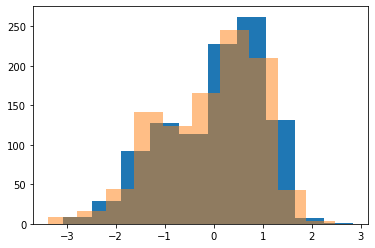

In [15]:
%matplotlib inline
plt.figure()
plt.hist(model.test_cond(1000).numpy()[:,0])
plt.hist(model.data_module.data[:1000,-2].numpy(),alpha=0.5)
plt.show()

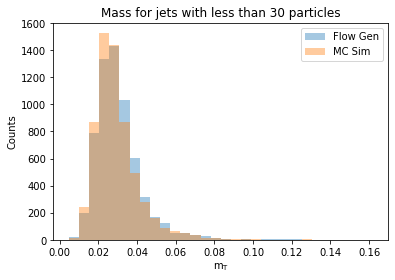

In [ ]:
test=data_module.test_set.cpu()
data_module.scaler.to("cpu")
model.flow=model.flow.to("cpu")
n=test[:,-1]
m=test[:,-2]

test=data_module.scaler.inverse_transform(test[:,:-1])
2
gen=model.flow.sample(1,torch.hstack((m.reshape(-1,1),n.reshape(-1,1)))).squeeze(1).detach()
gen=data_module.scaler.inverse_transform(torch.hstack((gen[:,:],torch.ones(len(gen),1))))[:,:-1]
m=test[:,-1]
m_g=mass(gen)
index=[n<30]
_,bins,_=plt.hist(m_g[index].detach().cpu().numpy(),bins=30,label="Flow Gen",alpha=0.4)
plt.hist(m[index].detach().cpu().numpy(),bins=bins,label="MC Sim",alpha=0.4)
plt.xlabel("$m_T$")
plt.ylabel("Counts")
plt.title("Mass for jets with less than 30 particles")
plt.legend()

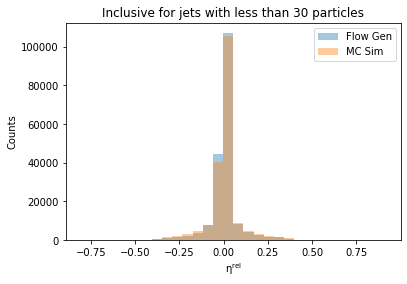

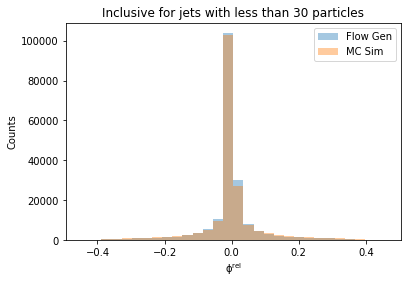

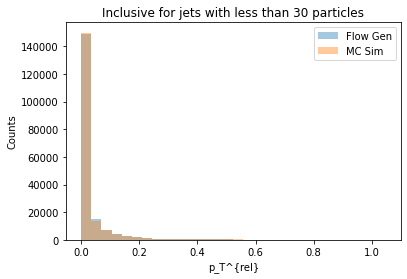

In [ ]:
cols=["$\eta^{rel}$","$\phi^{rel}$","p_T^{rel}"]
for i in range(3):
    
    _,bins,_=plt.hist(gen[index].reshape(-1,3)[:,i].detach().cpu().numpy(),bins=30,label="Flow Gen",alpha=0.4)
    plt.hist(test[index][:,:90].reshape(-1,3)[:,i].detach().cpu().numpy(),bins=bins,label="MC Sim",alpha=0.4)
    plt.xlabel(cols[i])
    plt.ylabel("Counts")
    plt.title("Inclusive for jets with less than 30 particles")
    plt.legend()
    plt.show()


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


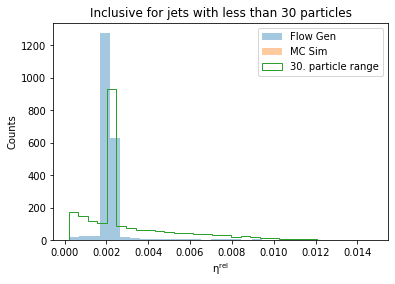

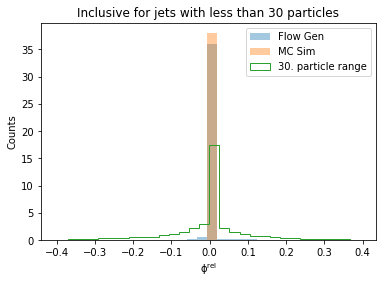

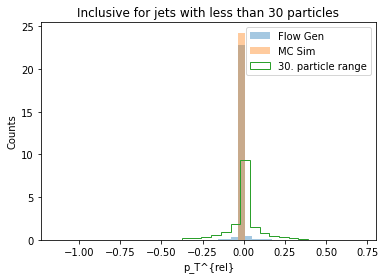

In [ ]:
cols=["$\eta^{rel}$","$\phi^{rel}$","p_T^{rel}"]
for i in range(3):
    
    _,bins,_=plt.hist(gen[index][:,-i-1].detach().cpu().numpy(),bins=30,label="Flow Gen",alpha=0.4,density=1)
    plt.hist(test[index][:,:90][:,-i-2].detach().cpu().numpy(),bins=bins,label="MC Sim",alpha=0.4,density=1)
    plt.hist(test[:,-i-2].detach().cpu().numpy(),bins=30,histtype="step",label="30. particle range",density=1)
    plt.xlabel(cols[i])
    plt.ylabel("Counts")
    plt.title("Inclusive for jets with less than 30 particles")
    plt.legend()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import os
import hist
import mplhep as hep
import torch
import numpy as np
import hist
from hist import Hist
import traceback
from helpers import mass
import pandas as pd
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
class plotting():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,true,gen,config,step,model=None,logger=None,):
        self.config=model.config
        self.n_dim=self.config["n_dim"]
        self.gen=gen
        self.test_set=true
        self.step=step
        self.model=model
        if logger is not None:
            self.summary=logger
       
    def plot_marginals(self,save=False):
        #This plots the marginal distribution for simulation and generation
        #Note that this is the data the model sees during training as input to model in the NF
        #This is the distribution of one of [eta,phi,pt] of one particle of the n particles per jet: for example the pt of the 3rd particle
        #if save, the histograms are logged to tensorboard otherwise they are shown
        plt.switch_backend('agg')
        name,label=["eta","phi","pt"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$"]

        for i in range(self.n_dim):
            a=np.quantile(self.test_set[:,i].numpy(),0)
            b=np.quantile(self.test_set[:,i].numpy(),1)

            h=hist.Hist(hist.axis.Regular(15,a,b))
            h2=hist.Hist(hist.axis.Regular(15,a,b))
            h.fill(self.gen[:,i].numpy())
            h2.fill(self.test_set[:,i].numpy())
            fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(8,8))
            plt.tight_layout()
#             hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
       
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
                rp_ylabel=r"Ratio",
                rp_num_label="Flow Generated",
                rp_denom_label="MC Simulated",
                rp_uncert_draw_type="line"  # line or bar
            )

            ax[0].set_xlabel("")
            ax[1].set_xlabel(name,fontsize=28)
            ax[0].set_ylabel("Counts",fontsize=28)
            ax[1].set_ylabel("Ratio",fontsize=28)
            
            ax[1].set_ylim(0.25,2)
            ax[0].set_xlim(a,b)
            ax[1].set_xlim(a,b)
            plt.xlabel(label[i%3])
            plt.tight_layout(pad=2)
            if save:
                self.summary.add_figure("jet{}_{}".format(i//3+1,name[i%3]),fig,global_step=self.step)
                self.summary.close()
            else:
                plt.show()


    def plot_2d(self,save=False):
        #This creates a 2D histogram of the inclusive distribution for all 3 feature combinations
        #Inclusive means that is the distribution of pt of all particles per jet and sample
        #if save, the histograms are logged to tensorboard otherwise they are shown
        data=self.test_set[:,:self.n_dim].reshape(-1,3).numpy()
        gen=self.gen[:,:self.n_dim].reshape(-1,3).numpy()
        labels=[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$"]
        names=["eta","p3hi","pt"]
        for index in [[0,1],[0,2],[1,2]]:

            fig,ax=plt.subplots(ncols=2,figsize=(16, 8))
            _,x,y,_=ax[0].hist2d(data[:,index[0]],data[:,index[1]],bins=30)
            
            if index[1]==2:
                
                y = np.logspace(np.log(y[0]),np.log(y[-1]),len(y))
                ax[0].hist2d(data[:,index[0]],gen[:,index[1]],bins=[x,y])
            ax[1].hist2d(gen[:,index[0]],gen[:,index[1]],bins=[x,y])
            plt.tight_layout(pad=2)
            ax[0].set_xlabel( labels[index[0]])
            ax[0].set_ylabel( labels[index[1]])
            
            ax[0].set_title("Data")
            ax[1].set_xlabel( labels[index[0]])
            ax[1].set_ylabel( labels[index[1]])
            
            ax[1].set_title("Gen")
           
            if save:
                self.summary.add_figure("2d{}-{}".format(names[index[0]],names[index[1]]),fig,global_step=self.step)
                
                # self.summary.close()
            else:
                plt.show()
 
        
    def plot_mass(self,m,m_t,save=False,quantile=False,bins=15,plot_vline=True):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0


        gen=self.gen[:,:self.n_dim].reshape(-1,3).numpy()
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$",r"$m_T^{rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i])
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                bins = h.axes[0].edges
                h.fill(m)
                h2.fill(m_t)
            fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(8,8))
#             hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            try:
                main_ax_artists, sublot_ax_arists = h.plot_ratio(
                    h2,
                    ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
                    rp_ylabel=r"Ratio",
                    rp_num_label="Flow Generated",
                    rp_denom_label="MC Simulated",
                    rp_uncert_draw_type="line",  # line or bar
                )
                ax[0].set_xlabel("")
                if quantile and v=="m" and plot_vline:
                    ax[0].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile Flow Generated",hatch="/")
                    ax[0].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile MC Simulated')
                    
                ax[1].set_ylim(0.25,2)
                ax[0].set_xlim(a,b)
                
                ax[1].set_xlim(a,b)
                if v!="m":
                    ax[0].legend(["Flow Generated","MC Simulatied"])
                elif plot_vline:
                    ax[0].legend(["Flow Generated","MC Simulated","10% quantile Flow Generated","10% quantile MC Simulation"] )
            except:
                print("mass plot failed reverting to simple plot mass bins")
                plt.close()
                plt.figure()
                _,b,_=plt.hist(m_t,15,label="Sim",alpha=0.5)
                plt.hist(m,b,label="Gen",alpha=0.5)
                plt.legend()  
           # hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            ax[1].set_xlabel(name,fontsize=28)
            ax[0].set_ylabel("Counts",fontsize=28)
            ax[1].set_ylabel("Ratio",fontsize=28)
            
            plt.tight_layout(pad=2)
            if save:
                if v!="m":
                     self.summary.add_figure("inclusive"+v,fig,self.step)
                else:
                    self.summary.add_figure("jet_mass",fig,self.step)
    #             print("added figure")
    #             self.summary.close()
            else:
                plt.show()

    def losses(self,save=False):
        '''This plots the different losses vs epochs'''
        fig=plt.figure()
        hep.cms.label("Private Work",data=None,lumi=None,year=None)
        plt.xlabel('step')
        plt.ylabel('loss')
        ln1=plt.plot(self.model.logprobs,label='log$(p_{gauss}(x_{data}))$')
        if "calc_massloss" in self.config.keys() and self.config["calc_massloss"]:
            plt.twinx()
            ln2=plt.plot(self.model.mlosses,label=r'mass mse $\times$ {}'.format(self.config["lambda"]),color='orange')
            plt.ylabel("MSE")
            plt.yscale("log")
            ln1+=ln2
        labs=[l.get_label() for l in ln1]
        plt.legend(ln1,labs)
        plt.tight_layout(pad=2)
        if save:
            self.summary.add_figure("losses",fig,self.step)
#             self.summary.close()
        else:
            plt.show()
    def plot_scores(self,scores_T,scores_gen,save=False):
        '''This plots the score distribution of the discriminator evaluated on true (simulated) sample scores_T 
        and on generated samples scores_gen'''
        fig=plt.figure()
        a=min(np.quantile(scores_gen,0.001),np.quantile(scores_T,0.001))
        b=max(np.quantile(scores_gen,0.999),np.quantile(scores_T,0.999))
        hep.cms.label("Private Work",data=None,lumi=None,year=None)
        plt.xlabel('Score')
        plt.ylabel('Counts')
        plt.suptitle("Discriminator Prediction")
        _,b,_=plt.hist(scores_T,label="MC Sim",alpha=0.5,bins=np.linspace(a,b,30))
        plt.hist(scores_gen,b,label="Flow Gen",alpha=0.5)
        plt.legend()
        plt.tight_layout(pad=2)
        if save:
            self.summary.add_figure("scores",fig,self.step)
#             self.summary.close()
        else:
            plt.show()
    def plot_cond(self,save=False):
        
        data_module=self.model.data_module
        fig,ax=plt.subplots(1)
        hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax )
        c=torch.ones(N).reshape(-1,1)*(-1)
        gen=self.model.flow.to("cpu").sample(1,c).reshape(-1,90).to("cpu")
        gen=self.model.data_module.scaler.to("cpu").inverse_transform(torch.hstack((gen,torch.ones(N).reshape(-1,1))))
        gen_trafo=torch.clone(gen)
        m=mass(gen[:,:90])
        gen=self.data_module.scaler.transform(torch.hstack((gen[:,:90],m.reshape(-1,1))))
        m=gen[:,-1]
        plt.ylabel("Counts [a.u.]",fontsize=28)
        plt.xlabel(r"$m^{scaled}$ [a.u]",fontsize=28)
        _,b,_=plt.hist((self.data_module.data)[:,-1].numpy(),bins=100,label="Training Data",alpha=0.5)
        plt.hist(m.detach().numpy(),bins=b,label="$m_{cond}=%d$"%c.numpy()[0],alpha=0.5)
        plt.legend()
        plt.show()
        gamma=0.2
        gen_trafo=gen_trafo[:,:90].detach().numpy()[:N,:90]#
        test_set_trafo=data_module.scaler.inverse_transform(data_module.test_set[(data_module.test_set[:,-1]<gamma+c[0])
                                        &(data_module.test_set[:,-1]>c[0]-gamma)])[:N,:90].numpy()[:N,:]

        for v,name in zip(["eta","phi","pt"],[r"$\eta^{rel}_{tot}$",r"$\phi^{rel}_{tot}$",r"$p_{T,tot}^{rel}$"]):
            a=min(np.quantile(gen_trafo.reshape(-1,3)[:N,i],0.001),np.quantile(test_set_trafo.reshape(-1,3)[:N,i],0.001))
            b=max(np.quantile(gen_trafo.reshape(-1,3)[:N,i],0.999),np.quantile(test_set_trafo.reshape(-1,3)[:N,i],0.999))     
            h=hist.Hist(hist.axis.Regular(15,a,b))
            h2=hist.Hist(hist.axis.Regular(15,a,b))
            h.fill(gen_trafo.reshape(-1,3)[:N,i])
            h2.fill(test_set_trafo.reshape(-1,3)[:N,i])
            i+=1
            fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(14,14))
            hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
                rp_ylabel=r"Ratio",
                rp_num_label="Generated $m^{scaled}_{cond}=%d\pm %1.2f$"%(c.numpy()[0],gamma),
                rp_denom_label="Simulated $m^{scaled}=%d\pm %1.2f$"%(c.numpy()[0],gamma),
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0].set_xlabel(None)
            hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            plt.xlabel(name)
            plt.tight_layout(pad=2)
        if save:
            self.summary.add_figure("scores",fig,self.step)
#             self.summary.close()
        else:
            plt.show()

    def plot_marg_cond(self,save=False):
        
        data_module=self.model.data_module
        fig,ax=plt.subplots(1)
        hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax )
        c=torch.ones(N).reshape(-1,1)*(-1)
        gen=self.model.flow.to("cpu").sample(1,c).reshape(-1,90).to("cpu")
        gen=self.model.data_module.scaler.to("cpu").inverse_transform(torch.hstack((gen,torch.ones(N).reshape(-1,1))))
        gen_trafo=torch.clone(gen)
        m=mass(gen[:,:90])
        gen=self.data_module.scaler.transform(torch.hstack((gen[:,:90],m.reshape(-1,1))))
        m=gen[:,-1]
        plt.ylabel("Counts [a.u.]")
        plt.xlabel(r"$m^{scaled}$ [a.u]")
        _,b,_=plt.hist((self.data_module.data)[:,-1].numpy(),bins=100,label="Training Data",alpha=0.5)
        plt.hist(m.detach().numpy(),bins=b,label="$m_{cond}=%d$"%c.numpy()[0],alpha=0.5)

        plt.legend()
        plt.show()

        gamma=0.2
        gen_trafo=gen_trafo[:,:90].detach().numpy()[:N,:90]#
        test_set_trafo=data_module.scaler.inverse_transform(data_module.test_set[(data_module.test_set[:,-1]<gamma+c[0])
                                        &(data_module.test_set[:,-1]>c[0]-gamma)])[:N,:90].numpy()[:N,:]
        i=0
        for v,name in zip(["eta","phi","pt"],[r"$\eta_1^{rel}$",r"$\phi_1^{rel}$",r"$p_{1,T}^{rel}$"]):
            a=min(np.quantile(gen_trafo[:N,i],0.001),np.quantile(test_set_trafo[:N,i],0.001))
            b=max(np.quantile(gen_trafo[:N,i],0.999),np.quantile(test_set_trafo[:N,i],0.999))     
            h=hist.Hist(hist.axis.Regular(15,a,b))
            h2=hist.Hist(hist.axis.Regular(15,a,b))
            h.fill(gen_trafo[:N,i])
            h2.fill(test_set_trafo[:N,i])
            i+=1
            fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(14,14))
            hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
                rp_ylabel=r"Ratio",
                rp_num_label="Generated $m^{scaled}_{cond}=%d\pm %1.2f$"%(c.numpy()[0],gamma),
                rp_denom_label="Simulated $m^{scaled}=%d\pm %1.2f$"%(c.numpy()[0],gamma),
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0].set_xlabel(None)
            hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            plt.xlabel(name)
            plt.tight_layout(pad=2)
            if save:
                self.summary.add_figure("scores",fig,self.step)
    #             self.summary.close()
            else:
                plt.show()
    def plot_correlations(self,save=True):
        #Plots correlations between all particles for i=0 eta,i=1 phi,i=2 pt
        self.plot_corr(i=0,save=save)
        self.plot_corr(i=1,save=save)
        self.plot_corr(i=2,save=save)

    def plot_corr(self,i=0,names=["$\eta^{rel}$","$\phi^{rel}$","$p_T$"],save=True):
        if i==2:
            c=1
        else:
            c=.25
        df_g=pd.DataFrame(self.gen[:,:self.n_dim].detach().numpy()[:,range(i,90,3)])
        df_h=pd.DataFrame(self.test_set[:,:self.n_dim].detach().numpy()[:,range(i,90,3)])
        
        fig,ax=plt.subplots(ncols=2,figsize=(15,7.5))
        corr_g = ax[0].matshow(df_g.corr())
        corr_g.set_clim(-c,c)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar=fig.colorbar(corr_g,cax=cax)

        corr_h = ax[1].matshow(df_h.corr())
        corr_h.set_clim(-c,c)
        divider = make_axes_locatable(ax[1])

        cax2 = divider.append_axes('right', size='5%', pad=0.05)
        cbar=fig.colorbar(corr_h,cax=cax2)
        plt.suptitle("{} Correlation between Particles".format(names[i]),fontsize=38)
        ax[0].set_title("Flow Generated",fontsize=34)
        ax[1].set_title("MC Simulated",fontsize=28)
        ax[0].set_xlabel("Particles",fontsize=28)
        ax[0].set_ylabel("Particles",fontsize=28)
        ax[1].set_xlabel("Particles",fontsize=28)
        ax[1].set_ylabel("Particles",fontsize=28)
        ax[0].set_xticks([])
        ax[1].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_yticks([])
        if save:
                title=["corr_eta","corr_phi","corr_pt"]
                self.summary.add_figure(title[i],fig,self.step)
                
    #             self.summary.close()
        else:
                plt.show()
batch=model.data_module.test_set.to("cpu")
model2=model
model.q0.temp=1
model2.flow = base.Flow(distribution=model.q0, transform=model.flows)
true=model.data_module.scaler.inverse_transform(batch[:,:-1].cpu())
with torch.no_grad():
    if model.config["context_features"]:
        gen=model.flow_test.to("cpu").sample(1,batch[:,model.n_dim:].reshape(-1,model.config["context_features"]).to("cpu"))  
        gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))
    else:
            gen=model.flow.to("cpu").sample(len(true)).to("cpu")
            
gen=model.data_module.scaler.inverse_transform(gen)
if model.config["context_features"]>1:
    for i in torch.unique(batch[:,-1]):
        i=int(i)
        gen[batch[:,-1]==i,3*i:]=0

logprob = -model.flow.to("cpu").log_prob(batch[:,:model.n_dim],batch[:,model.n_dim:]).detach().mean().numpy()/model.n_dim


m_t=mass(true[:,:model.n_dim].to(model.device))
m_gen=mass(gen[:,:model.n_dim],model.config["canonical"])
gen=torch.column_stack((gen[:,:90],m_gen))


plot=plotting(model=model,gen=gen[:,:90],true=true[:,:90],config=config,step=0,logger=model.logger.experiment)
try:
    plot.plot_mass(m_gen.cpu().numpy(),m_t.cpu().numpy(),save=False,bins=30,quantile=True,plot_vline=False)
#     plot.plot_marginals(save=False)
    plot.plot_2d(save=True)
    plot.losses(save=True)

except Exception as e:
    traceback.print_exc()

# #         self.flow.to("cuda")
plot.plot_correlations(save=False)

In [ ]:
## import torch
# from torch.utils.data import DataLoader
# import pytorch_lightning as pl   
# from sklearn.model_selection import train_test_split
# import os
# import pandas as pd
# import numpy as np
# from helpers import *

# # import matplotlib.pyplot as plt

# class StandardScaler:

#     def __init__(self, mean=None, std=None, epsilon=1e-7):
#         """Standard Scaler.
#         The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
#         tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
#         will work fine.
#         :param mean: The mean of the features. The property will be set after a call to fit.
#         :param std: The standard deviation of the features. The property will be set after a call to fit.
#         :param epsilon: Used to avoid a Division-By-Zero exception.
#         """
#         self.mean = mean
#         self.std = std
#         self.epsilon = epsilon

#     def fit(self, values):
#         dims = list(range(values.dim() - 1))
#         self.mean = torch.mean(values, dim=dims)
#         self.std = torch.std(values, dim=dims)

#     def transform(self, values):
#         return (values - self.mean) / (self.std + self.epsilon)
#     def inverse_transform(self,values):
#         return (values *self.std)+self.mean
#     def fit_transform(self, values):
#         self.fit(values)
#         return self.transform(values)
#     def to(self,dev):
#         self.std=self.std.to(dev)
#         self.mean=self.mean.to(dev)
#         return self
  
# class JetNetDataloader(pl.LightningDataModule):
#     '''This is more or less standard boilerplate coded that builds the data loader of the training
#        one thing to note is the custom standard scaler that works on tensors
#        Currently only jets with 30 particles are used but this maybe changes soon'''
#     def __init__(self,config): 
#         super().__init__()
#         self.config=config
#         self.n_dim=config["n_dim"]
#         self.batch_size=config["batch_size"]
#     def setup(self,stage):
#     # transforms for images
#         data_dir=os.environ["HOME"]+"/JetNet_NF/train_{}_jets.csv".format("t")
#         data=pd.read_csv(data_dir,sep=" ",header=None)
#         jets=[]
#         limit=int(self.config["limit"]*1.1)
# #         for njets in range(0,31):
#         masks=np.sum(data.values[:,np.arange(3,120,4)],axis=1)
#         df=data.loc[masks==njets,:]
# #             vals=df.values
#         df=df.drop(np.arange(3,120,4),axis=1)
# #             df=df.iloc[:,:3*njets]
            
# #             if len(df)>0:
# #                 big=big.append(df)
# #                 jets.append(df.values[:self.config["limit"]])
#         self.data=torch.tensor(df.values[:,:self.n_dim]).float()
#         self.masks=masks
#         self.scaler=StandardScaler()
#         if self.config["canonical"]:
#             self.data=preprocess(self.data)
#         if  self.config["conditional"]:
#             self.m=mass(self.data[:,:self.n_dim],self.config["canonical"]).reshape(-1,1)
      
        
#         self.data=torch.hstack((self.data,self.m))
#         self.scaler.fit(self.data)
#         self.data=self.scaler.transform(self.data)
       
#         self.data,self.test_set,self.n,self.n_test=train_test_split(self.data.cpu().numpy(),masks,test_size=0.1)
#         self.test_set=torch.tensor(self.test_set).float()
#         self.data=torch.tensor(self.data).float()
#         self.n=torch.tensor(self.n).float()
#         self.n_test=torch.tensor(self.n_test).float()
#         assert (torch.isnan(self.data)).sum()==0
#         assert self.data.shape[1]==self.n_dim+1
#         # plt.hist(self.scaler.inverse_transform(torch.vstack((self.data,self.test_set)))[:,self.n_dim].numpy(),bins=30,alpha=0.3,label='reversescaled')
#         # plt.hist(self.m.numpy(),bins=30,alpha=0.3,label='true')
#         # plt.legend()
#         # plt.show()
        
#     def train_dataloader(self):
#         return DataLoader([self.data,self.n], batch_size=self.batch_size)
#     def val_dataloader(self):
#         return DataLoader([self.test_set,self.n_test], batch_size=len(self.test_set))
        

In [ ]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def reorder(x):
    x=x[:,:90].reshape(-1,30,3)
    order,index=x.reshape(-1,30,3)[:,:,2].sort(descending=True)
    first_indices = torch.arange(len(x))[:, None]
    return x[first_indices, index].reshape(-1,90)

gen_mp=torch.load("/home/kaechben/MPGAN/datasets/t.pt")[:,:,:3].reshape(-1,90)
true=model.data_module.data
gen=model.flow.to("cpu").sample(1,true[:,model.n_dim].reshape(-1,1).to("cpu")).to("cpu")
gen=model.data_module.scaler.to("cpu").inverse_transform(torch.hstack((gen[:,:model.n_dim].cpu().detach()
                    .reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))))[:,:90]
print(gen.shape)
# def plot_correlations(self,gen,true,save=False):
gen_ordered=gen#.copy()#reorder(gen[:,:90])
#true_ordered=reorder(model.data_module.data[:,:90])
true=model.data_module.data[:,:90]
def plot_corr(gen,true,i=0,names=["$\eta$","$\phi$","$p_T$"]):
    if i==2:
        c=1
    else:
        c=.25
    df_g=pd.DataFrame(gen.detach().numpy()[:,range(i,90,3)])
    df_h=pd.DataFrame(true.detach().numpy()[:,range(i,90,3)])
    fig,ax=plt.subplots(ncols=2,figsize=(30,15))
    corr_g = ax[0].matshow(df_g.corr())
    corr_g.set_clim(-c,c)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar=fig.colorbar(corr_g,cax=cax)

    corr_h = ax[1].matshow(df_h.corr())
    corr_h.set_clim(-c,c)
    divider = make_axes_locatable(ax[1])

    cax2 = divider.append_axes('right', size='5%', pad=0.05)
    cbar=fig.colorbar(corr_h,cax=cax2)
    plt.suptitle("{} Correlation between Particles".format(names[i]))
    ax[0].set_title("Flow Generated")
    ax[1].set_title("MC Simulated")
    ax[0].set_xlabel("Particles")
    ax[0].set_ylabel("Particles")
    ax[1].set_xlabel("Particles")
    ax[1].set_ylabel("Particles")
    plt.show()
                
plot_corr(gen,true,i=0)
plot_corr(gen_mp,true,i=0)
plot_corr(gen,true,i=1)
plot_corr(gen_mp,true,i=1)
plot_corr(gen,true,i=2)
plot_corr(gen_mp,true,i=2)

In [ ]:
def reorder(x):
    x=x[:,:90].reshape(-1,30,3)
    order,index=x.reshape(-1,30,3)[:,:,2].sort(descending=True)
    first_indices = torch.arange(len(x))[:, None]
    return x[first_indices, index]

true=model.data_module.scaler.to("cpu").inverse_transform(model.data_module.data.cpu())[:1000,:]

gen=model.flow.to("cpu").sample(1,true[:,model.n_dim].reshape(-1,1).to("cpu")).to("cpu")
gen=model.data_module.scaler.inverse_transform(torch.hstack((gen[:,:model.n_dim].cpu().detach()
                    .reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))))[:,:90]


reorder(gen[0:2]).reshape(-1,30,3)


In [ ]:
x=torch.rand(180).reshape(-1,30,3)
index=x.argsort(dim=1)[1]
gen.reshape(-1,30,3).argsort(dim=1)

In [ ]:
plt.hist(data_module.data[:,-1].numpy())
plt.show()
plt.hist(data_module.scaler.inverse_transform(data_module.data)[:,:90].reshape(-1,3)[:,-1].numpy(),bins=30)

In [ ]:
N=10000
data_module=model.data_module
fig,ax=plt.subplots(1)
hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax )
c=torch.ones(N).reshape(-1,1)*(1)
gen=model.flow.to("cpu").sample(1,c).reshape(-1,90).to("cpu")
gen=model.data_module.scaler.to("cpu").inverse_transform(torch.hstack((gen,torch.ones(N).reshape(-1,1))))
gen_trafo=torch.clone(gen)
m=mass(gen[:,:90])
gen=data_module.scaler.transform(torch.hstack((gen[:,:90],m.reshape(-1,1))))
m=gen[:,-1]
plt.ylabel("Counts [a.u.]")
plt.xlabel(r"$m^{scaled}$ [a.u]")
_,b,_=plt.hist((data_module.data)[:,-1].numpy(),bins=100,label="Simulated",alpha=0.5)
plt.hist(m.detach().numpy(),bins=b,label="Generated $m_{cond}=%d$"%c.numpy()[0],alpha=0.5)

plt.legend()
plt.show()
i=0
gamma=0.2
gen_trafo=gen_trafo[:,:90].detach().numpy()[:N,:90]#
test_set_trafo=data_module.scaler.inverse_transform(data_module.data[(data_module.data[:,-1]<gamma+c[0])&(data_module.data[:,-1]>c[0]-gamma)])[:N,:90].numpy()[:N,:]#
N=min(len(gen_trafo),len(test_set_trafo))
i=0
for v,name in zip(["eta","phi","pt"],[r"$\eta^{rel}_{tot}$",r"$\phi^{rel}_{tot}$",r"$p_{T,tot}^{rel}$"]):
    a=min(np.quantile(gen_trafo.reshape(-1,3)[:N,i],0.001),np.quantile(test_set_trafo.reshape(-1,3)[:N,i],0.001))
    b=max(np.quantile(gen_trafo.reshape(-1,3)[:N,i],0.999),np.quantile(test_set_trafo.reshape(-1,3)[:N,i],0.999))     
    h=hist.Hist(hist.axis.Regular(15,a,b))
    h2=hist.Hist(hist.axis.Regular(15,a,b))
    h.fill(gen_trafo.reshape(-1,3)[:N,i])
    h2.fill(test_set_trafo.reshape(-1,3)[:N,i])
    i+=1
    fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(14,14))
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    main_ax_artists, sublot_ax_arists = h.plot_ratio(
        h2,
        ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
        rp_ylabel=r"Ratio",
        rp_num_label="Flow Generated $m^{scaled}_{cond}=%d$"%(c.numpy()[0]),
        rp_denom_label="MC Simulated $m^{scaled}=%d\pm %1.2f$"%(c.numpy()[0],gamma),
        rp_uncert_draw_type="line",  # line or bar
    )
    ax[0].set_xlabel(None)
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    plt.xlabel(name)
    plt.tight_layout(pad=2)
i=0
for v,name in zip(["eta","phi","pt"],[r"$\eta_1^{rel}$",r"$\phi_1^{rel}$",r"$p_{1,T}^{rel}$"]):
    a=min(np.quantile(gen_trafo[:N,i],0.001),np.quantile(test_set_trafo[:N,i],0.001))
    b=max(np.quantile(gen_trafo[:N,i],0.999),np.quantile(test_set_trafo[:N,i],0.999))     
    h=hist.Hist(hist.axis.Regular(15,a,b))
    h2=hist.Hist(hist.axis.Regular(15,a,b))
    h.fill(gen_trafo[:N,i])
    h2.fill(test_set_trafo[:N,i])
    i+=1
    fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(14,14))
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    main_ax_artists, sublot_ax_arists = h.plot_ratio(
        h2,
        ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
        rp_ylabel=r"Ratio",
        rp_num_label="Flow Generated $m^{scaled}_{cond}=%d$"%(c.numpy()[0]),
        rp_denom_label="MC Simulated $m^{scaled}=%d\pm %1.2f$"%(c.numpy()[0],gamma),
        rp_uncert_draw_type="line",  # line or bar
    )
    ax[0].set_xlabel(None)
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    plt.xlabel(name)
    plt.tight_layout(pad=2)

In [ ]:
N=10000
data_module=model.data_module
fig,ax=plt.subplots(1)
hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax )
c=torch.ones(N).reshape(-1,1)*(7)
gen=model.flow.to("cpu").sample(1,c).reshape(-1,90).to("cpu")
gen=model.data_module.scaler.to("cpu").inverse_transform(torch.hstack((gen,torch.ones(N).reshape(-1,1))))
gen_trafo=torch.clone(gen)
m=mass(gen[:,:90])
gen=data_module.scaler.transform(torch.hstack((gen[:,:90],m.reshape(-1,1))))
m=gen[:,-1]
plt.ylabel("Counts [a.u.]")
plt.xlabel(r"$m^{scaled}$ [a.u]")

_,b,_=plt.hist((data_module.data)[:,-1].numpy(),bins=100,label="Simulated",alpha=0.5)
plt.hist(m.detach().numpy(),bins=b,label="Generated $m_{cond}=%d$"%c.numpy()[0],alpha=0.5)

plt.legend()
plt.show()
i=0
gamma=0.2
gen_trafo=gen_trafo[:,:90].detach().numpy()[:N,:90]#
test_set_trafo=data_module.scaler.inverse_transform(data_module.data)[:N,:90].numpy()[:N,:]#
N=min(len(gen_trafo),len(test_set_trafo))
i=0
for v,name in zip(["eta","phi","pt"],[r"$\eta^{rel}_{tot}$",r"$\phi^{rel}_{tot}$",r"$p_{T,tot}^{rel}$"]):
    a=min(np.quantile(gen_trafo.reshape(-1,3)[:N,i],0.001),np.quantile(test_set_trafo.reshape(-1,3)[:N,i],0.001))
    b=max(np.quantile(gen_trafo.reshape(-1,3)[:N,i],0.999),np.quantile(test_set_trafo.reshape(-1,3)[:N,i],0.999))     
    h=hist.Hist(hist.axis.Regular(15,a,b))
    h2=hist.Hist(hist.axis.Regular(15,a,b))
    h.fill(gen_trafo.reshape(-1,3)[:N,i])
    h2.fill(test_set_trafo.reshape(-1,3)[:N,i])
    i+=1
    fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(14,14))
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    main_ax_artists, sublot_ax_arists = h.plot_ratio(
        h2,
        ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
        rp_ylabel=r"Ratio",
        rp_num_label="Flow Generated $m^{scaled}_{cond}=%d$"%(c.numpy()[0]),
        rp_denom_label="MC Simulated $m^{scaled}$",
        rp_uncert_draw_type="line",  # line or bar
    )
    ax[0].set_xlabel(None)
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    plt.xlabel(name)
    plt.tight_layout(pad=2)
i=0
for v,name in zip(["eta","phi","pt"],[r"$\eta_1^{rel}$",r"$\phi_1^{rel}$",r"$p_{1,T}^{rel}$"]):
    a=min(np.quantile(gen_trafo[:N,i],0.001),np.quantile(test_set_trafo[:N,i],0.001))
    b=max(np.quantile(gen_trafo[:N,i],0.999),np.quantile(test_set_trafo[:N,i],0.999))     
    h=hist.Hist(hist.axis.Regular(15,a,b))
    h2=hist.Hist(hist.axis.Regular(15,a,b))
    h.fill(gen_trafo[:N,i])
    h2.fill(test_set_trafo[:N,i])
    i+=1
    fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(14,14))
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    main_ax_artists, sublot_ax_arists = h.plot_ratio(
        h2,
        ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
        rp_ylabel=r"Ratio",
        rp_num_label="Flow Generated $m^{scaled}_{cond}=%d$"%(c.numpy()[0]),
        rp_denom_label="MC Simulated $m^{scaled}$",
        rp_uncert_draw_type="line",  # line or bar
    )
    ax[0].set_xlabel(None)
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    plt.xlabel(name)
    plt.tight_layout(pad=2)

data_module = JetNetDataloader(config)
data_module.setup(stage=None)
model.data_module=data_module
plt.figure(figsize=(10,10))
plt.hist(m.detach().cpu().numpy()-m_g.detach().cpu().numpy(),bins=30)
plt.title("Mass Resolution")
textstr = '\n'.join((
    r'$\sigma_{sim}\cdot 10^{3}=%.1f$' % (m.detach().cpu().std().numpy()*1e3, ),
    r'$\sigma_{\Delta}\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().std().numpy()*1e3, ),
    r'$ (\bar{m}_{sim}-\bar{m}_{gen} )\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().mean().numpy()*1e3, )))

plt.text(-0.021,10**2.7,textstr,fontsize=20)
plt.xlabel("$m_{sim}-m_{gen}$")
plt.ylabel("Count")
plt.yscale("log")
plt.xlim(-0.023,0.023)
plt.show()

In [ ]:
plt.title("For condition=%.3f"%m_grid[i])
plt.xlabel("$m_{gen}$")
plt.ylabel("Count")
plt.xlim(m_grid[0],m_grid[-1])
true=data_module.test_set[:10000,:]
true[:,-1]=torch.ones(10000)*m_grid[0]
c=model.data_module.scaler.transform(true)[:,-1]
_,_,m,m_g=model.sampleandscale(true,c)
plt.hist(m_g.detach().cpu().numpy())

In [ ]:
# def plot_resolution(m,m_g,ax):

#     ax.hist(m-m_g.detach().cpu().numpy(),bins=30)
# #     plt.title("Mass Resolution")
# #     textstr = '\n'.join((
# #         r'$\sigma_{sim}\cdot 10^{3}=%.1f$' % (m.detach().cpu().std().numpy()*1e3, ),
# #         r'$\sigma_{\Delta}\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().std().numpy()*1e3, ),
# #         r'$ (\bar{m}_{sim}-\bar{m}_{gen} )\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().mean().numpy()*1e3, )))

# #     plt.text(-0.021,10**2.7,textstr,fontsize=20)
#     ax.set_xlabel("$m_{sim}-m_{gen}$")
#     ax.set_ylabel("Count")
#     ax.set_yscale("log")
#     ax.set_xlim(-0.3,0.3)  
#     ax.set_title("Condition m=%.3f"%m)
# _,_,m,m_g=model.sampleandscale(data_module.test_set[:10000,:],c=None)
# fig,axes=plt.subplots(nrows=5,ncols=5,figsize=(25,25))
# m_grid=np.linspace(m.min().detach().cpu().numpy(),m.max().detach().cpu().numpy(),25)
# print(m_grid)
# std=[]
# means=[]
# for i in range(25):
#     true=data_module.test_set[:10000,:]
#     true[:,-1]=torch.ones(10000)*m_grid[i]
#     c=model.data_module.scaler.to(model.device).transform(true.to(model.device))[:,-1]
#     _,_,m,m_g=model.sampleandscale(data_module.test_set[:10000,:],c=c)
#     plot_resolution(m_grid[i],m_g,axes[i//5,i%5])
#     means.append(np.mean(m_g.detach().cpu().numpy()-m_grid[i]))
#     std.append(np.std(m_g.detach().cpu().numpy()-m_grid[i]))
plt.tight_layout()
plt.show()
plt.plot(m_grid,std,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\sigma_{\Delta}$")
plt.show()
plt.plot(m_grid,means,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\Delta_{sim-gen}$")    
plt.show()

plt.title("Relative Resolution")
plt.plot(m_grid,np.array(std)/m_grid,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\sigma_{sim-gen}/m$")
plt.show()
plt.title("Relative Mean Error")
plt.plot(m_grid,means/m_grid,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\Delta_{sim-gen}/m$")           

In [ ]:
m_grid

In [ ]:
fig,ax=plt.subplots(nrows=6,ncols=5)
with torch.no_grad():
    gen=model.flow.sample(1,model.data_module.test_set[:1000,-1].reshape(-1,1).to(model.device)).reshape(-1,model.n_dim).to(model.device)
    gen=model.data_module.scaler.to(model.device).inverse_transform(torch.hstack((gen[:,:model.n_dim]
        .reshape(-1,model.n_dim),torch.ones(len(gen)).to(model.device).unsqueeze(1))))
    m_g=mass(gen[:,:model.n_dim].to(model.device) ,
             model.config["canonical"]).to(model.device) 
    true=model.data_module.scaler.inverse_transform(model.data_module.test_set[:1000].to(model.device)).to(model.device)

for i in range(model.n_dim//3):
    print(i)
    
    ax[i//5,i%5].hist(gen[:,i].cpu().numpy(),alpha=.5)
    ax[i//5,i%5].hist(true[:,i].cpu().numpy(),alpha=.5)
plt.show()

In [ ]:
def weights_update(model, checkpoint):
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

model = weights_update(model=LitNF(config), checkpoint=torch.load(path+ckpt))
model

In [ ]:

gen=model.flow.to("cpu").sample(1,model.data_module.test_set[:,model.n_dim].reshape(-1,1).to("cpu")).to("cpu")
model.data_module.scaler.to("cpu")
gen=model.data_module.scaler.inverse_transform(torch.hstack((gen[:,:model.n_dim].cpu().detach()
    .reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))))

In [ ]:
w1m(gen[:,:-1].reshape(-1,30,3).numpy(),data_module.scaler.inverse_transform(
    data_module.test_set)[:,:-1].numpy().reshape(-1,30,3))

In [ ]:
_,b,_=plt.hist(model.data_module.data[:,2].numpy(),bins=30,alpha=1,edgecolor='red',fill=None,histtype='stepfilled')
for i in range(1,model.data_module.data.shape[1]//3):
    
    plt.hist(model.data_module.data[:,2+3*i].numpy(),bins=b,alpha=1,color='red',fill=None,histtype='stepfilled')
plt.title("$p_T$ Comparison")
plt.ylabel("Counts")
plt.xlabel("$p_T^{rel}$")
plt.yscale('log')
plt.show()

In [ ]:
# gc.collect()
del model
torch.cuda.empty_cache()

In [ ]:
model=LitNF(config)
best_model=model.load_from_checkpoint(checkpoint_callback.best_model_path)
